### Imports

In [1]:
#Base
import pandas as pd
import numpy as np

#others

import itertools
import string
import re

#Visuals
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

#warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE

In [3]:
#nltk
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer, sent_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer, LancasterStemmer
from nltk import WordNetLemmatizer, pos_tag

### CSV File - EDA

In [4]:
#loading csv file

df = pd.read_csv('/Users/kellyjara/Desktop/Project_4/Data/judge-1377884607_tweet_product_company.csv', 
                encoding='latin-1')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [5]:
# Viewing columns and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [6]:
# Renaming column for easier callback/reference

df.rename(columns = {'is_there_an_emotion_directed_at_a_brand_or_product':'emotion'}, inplace = True)

In [7]:
#Viewing change 

df.head()

,tweet_text,emotion_in_tweet_is_directed_at,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [8]:
#checking NaN values in columns

df.isna().sum()

tweet_text                            1
emotion_in_tweet_is_directed_at    5802
emotion                               0
dtype: int64

In [9]:
# Dropping column as it is not needed for sentiment analysis

df.drop(columns = 'emotion_in_tweet_is_directed_at', inplace = True)

In [10]:
# Dropping NaN values in the df
df.dropna(axis = 0, inplace = True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9092 entries, 0 to 9092
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_text  9092 non-null   object
 1   emotion     9092 non-null   object
dtypes: object(2)
memory usage: 213.1+ KB


In [12]:
df['emotion'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: emotion, dtype: int64

In [13]:
# Dropping values that contain no emotion; Keeping only positive and negative emotions
df2 = df[df['emotion'] != "I can't tell"]
df2 = df2[df2['emotion'] != "No emotion toward brand or product"]

In [14]:
df2['emotion'].value_counts()

Positive emotion    2978
Negative emotion     570
Name: emotion, dtype: int64

In [15]:
# Creating emotion column into a numerical value
df2['target'] = df2['emotion'].astype('category')
categories = ['Positive emotion', 'Negative emotion']
df2['target'] = df2['target'].cat.reorder_categories(categories)
df2['target'] = df2['target'].cat.codes
df2['target'].value_counts()

0    2978
1     570
Name: target, dtype: int64

In [16]:
# Viewing 1st tweet in the df 
tweet_1 = df['tweet_text'].iloc[0]
tweet_1

'.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.'

<Axes: xlabel='emotion', ylabel='count'>

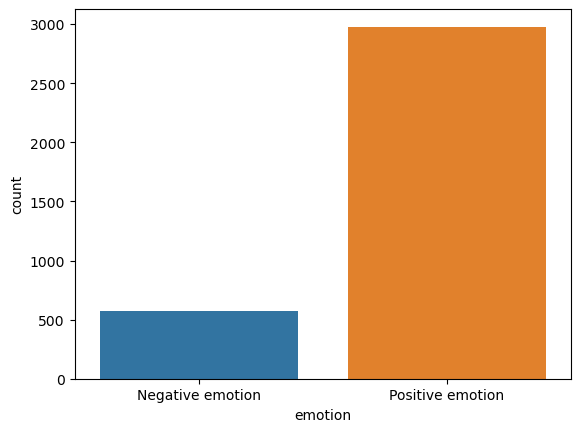

In [17]:
#Visualization of data distribution
sns.countplot(x = 'emotion', data = df2)

### Text PreProcessing 

In [18]:
def process_tweet(tweet_text, min_length):
    
    # get common stop words that we'll remove during tokenization/text normalization
    stop_words = stopwords.words('english')

    #initialize lemmatizer
    wnl = WordNetLemmatizer()

    # helper function to change nltk's part of speech tagging to a wordnet format.
    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('JJ'):
            return wordnet.ADJ
        elif nltk_tag.startswith('VB'):
            return wordnet.VERB
        elif nltk_tag.startswith('NN'):
            return wordnet.NOUN
        elif nltk_tag.startswith('RB'):
            return wordnet.ADV
        else:         
            return None
   

    # lower case everything
    tweet_lower = tweet_text.lower()

    #remove mentions, hashtags, and urls, strip whitspace and breaks
    tweet_lower = re.sub(r"@[a-z0-9_]+|#[a-z0-9_]+|http\S+", "", 
                         tweet_lower).strip().replace("\r", "").replace("\n", "").replace("\t", "")
    
    #removing special characters 
    tweet_spec = re.sub(r"[^a-zA-Z0-9 ]", "", tweet_lower)
    
    
    # remove stop words and punctuations 
    tweet_norm = [x for x in word_tokenize(tweet_spec) if ((x.isalpha()) & (x not in stop_words)) ]
    
    # creates list of tuples with tokens and POS tags in wordnet format
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(tweet_norm))) 

    # rejoining lemmatized sentence 
    tweet_norm = " ".join([wnl.lemmatize(x[0], x[1]) for x in wordnet_tagged if x[1] is not None])
    return tweet_norm

In [19]:
df2['norm_tweet'] = df2['tweet_text'].apply(process_tweet, args = [3])
df2

,tweet_text,emotion,target,norm_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion,1,iphone hr tweet dead need upgrade plugin station
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion,0,know awesome ipadiphone app youll likely appre...
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion,0,wait also sale
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion,1,hope year festival isnt crashy year iphone app
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion,0,great stuff fri mayer google tim oreilly tech ...
...,...,...,...,...
9077,@mention your PR guy just convinced me to swit...,Positive emotion,0,pr guy convince switch back iphone great coverage
9079,&quot;papyrus...sort of like the ipad&quot; - ...,Positive emotion,0,quotpapyrussort ipadquot nice lol lavelle
9080,Diller says Google TV &quot;might be run over ...,Negative emotion,1,diller say google tv quotmight run playstation...
9085,I've always used Camera+ for my iPhone b/c it ...,Positive emotion,0,ive always use camera iphone bc image stabiliz...


In [20]:
df3 = df2['tweet_text'].apply(process_tweet, args = [3])
df3

0        iphone hr tweet dead need upgrade plugin station
1       know awesome ipadiphone app youll likely appre...
2                                          wait also sale
3          hope year festival isnt crashy year iphone app
4       great stuff fri mayer google tim oreilly tech ...
                              ...                        
9077    pr guy convince switch back iphone great coverage
9079            quotpapyrussort ipadquot nice lol lavelle
9080    diller say google tv quotmight run playstation...
9085    ive always use camera iphone bc image stabiliz...
9088                                 ipad everywhere link
Name: tweet_text, Length: 3548, dtype: object

### Vectorizing

In [21]:
#Train-Test-Split
X = df2['norm_tweet']
y = df2['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [22]:
X_train

4460    town sure check use google place foursquare ki...
1803    new look go rock update iphone android push to...
2489    pack charge ipad busy dayweekend ahead also ne...
6372    rt regel quotgoogle tweetquot new quotthink sp...
7709    cool internet art google eat google ad revenue...
                              ...                        
8727    stellar customer service store wish purchase s...
98      fast fun amp future google present search loca...
2865    google prefers launch hype new social feature ...
8993    look interest good luck localmind available ip...
7440    google tip launch social network today call ci...
Name: norm_tweet, Length: 2838, dtype: object

#### CountVectorizer

In [23]:
cv = CountVectorizer()
cv_X_train = cv.fit_transform(X_train)
cv_X_test= cv.transform(X_test)
cv.get_feature_names_out()

array(['aapl', 'abacus', 'abandon', ..., 'zone', 'zoom', 'zzzs'],
      dtype=object)

#### TfidfVectorizer

In [24]:
vec = TfidfVectorizer()

vec.fit(X_train)
X_train_vec = vec.transform(X_train)
X_test_vec = vec.transform(X_test)
 

pd.DataFrame(X_train_vec.toarray(), columns = vec.get_feature_names_out())

,aapl,abacus,abandon,aber,able,abroad,absolute,absolutely,abt,abuzz,...,zappos,zazzle,zero,zip,zms,zombie,zomg,zone,zoom,zzzs
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2834,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2835,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2836,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
len(vec.get_feature_names_out())
vec.get_feature_names_out()

array(['aapl', 'abacus', 'abandon', ..., 'zone', 'zoom', 'zzzs'],
      dtype=object)

### Topic Modeling

### topic modeling - gensim

In [26]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess

In [90]:
top_mod = NMF(n_components = 2)
top_mod.fit(cv_X_train)

NMF(n_components=2)

In [91]:
H = top_mod.transform(cv_X_train)
W = top_mod.components_

print("Shape of W is" + str(W.shape))
print("Shape of H is" + str(H.shape))
print("Shape of train is" + str(cv_X_train.shape))

Shape of W is(2, 4171)
Shape of H is(2838, 2)
Shape of train is(2838, 4171)


In [92]:
# 2,838 tweets in this train set
# 3,598 features

In [93]:
for index,topic in enumerate(W):
    print(f'THE TOP 10 WORDS FOR Emotion{index}')
    print([vec.get_feature_names_out()[i] for i in topic.argsort()[-25:]])
    print('\n')

THE TOP 10 WORDS FOR Emotion0
['day', 'ipads', 'win', 'launch', 'begin', 'shop', 'sell', 'temp', 'buy', 'even', 'set', 'pop', 'sxsw', 'get', 'rt', 'temporary', 'downtown', 'line', 'ipad', 'open', 'austin', 'popup', 'link', 'store', 'apple']


THE TOP 10 WORDS FOR Emotion1
['map', 'free', 'time', 'use', 'party', 'android', 'possibly', 'come', 'go', 'amp', 'major', 'call', 'get', 'today', 'network', 'circle', 'social', 'launch', 'app', 'iphone', 'new', 'ipad', 'google', 'link', 'rt']




In [31]:
vec_df = pd.DataFrame(cv_X_train.toarray(), columns = cv.get_feature_names_out())
vec_df['target'] = y_train
vec_df

,aapl,abacus,abandon,aber,able,abroad,absolute,absolutely,abt,abuzz,...,zappos,zazzle,zero,zip,zms,zombie,zomg,zone,zoom,zzzs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2833,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2834,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2835,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2836,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
vec_df['target'].value_counts()

0.0    782
1.0    154
Name: target, dtype: int64

In [33]:
vec_df.iloc[200].sort_values(ascending = False)[:10]

link       1.0
get        1.0
lonely     1.0
ipad       1.0
someone    1.0
ta         1.0
protect    1.0
job        1.0
prop       0.0
proof      0.0
Name: 200, dtype: float64

### Model Eval - CtVectorizer

#### Model imports

In [34]:
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, precision_score

### Logistic Regression

In [35]:
from sklearn.linear_model import LogisticRegression

              precision    recall  f1-score   support

           0       0.89      0.96      0.93       606
           1       0.59      0.31      0.41       104

    accuracy                           0.87       710
   macro avg       0.74      0.64      0.67       710
weighted avg       0.85      0.87      0.85       710



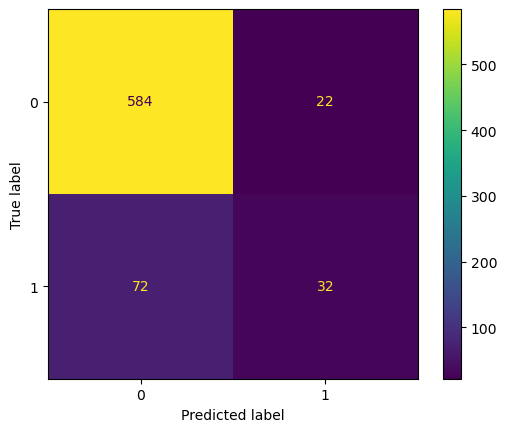

In [36]:
logreg = LogisticRegression()

logreg.fit(cv_X_train, y_train)
preds = logreg.predict(cv_X_test)

print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
ConfusionMatrixDisplay(cm).plot()

In [37]:
print(logreg.score(cv_X_train, y_train))
print(logreg.score(cv_X_test, y_test))

0.9630021141649049
0.8676056338028169


In [38]:
roc_auc_score(y_test, preds)

0.6356943386646358

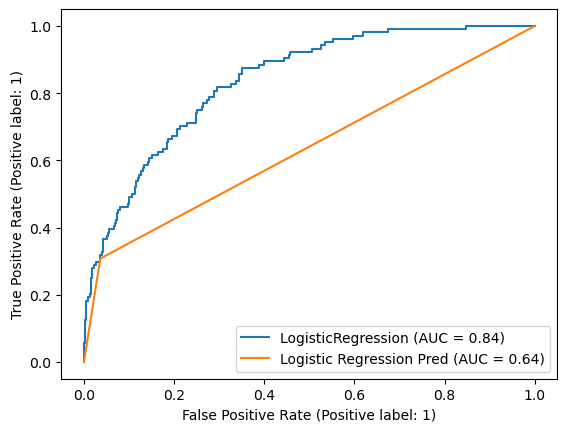

In [39]:
fig, ax = plt.subplots()

RocCurveDisplay.from_estimator(logreg, cv_X_test, y_test, ax = ax)
RocCurveDisplay.from_predictions(y_test, preds ,ax=ax,name="Logistic Regression Pred")

### Bernoulli model 

In [40]:
from sklearn.naive_bayes import BernoulliNB

              precision    recall  f1-score   support

           0       0.87      0.99      0.93       606
           1       0.73      0.15      0.25       104

    accuracy                           0.87       710
   macro avg       0.80      0.57      0.59       710
weighted avg       0.85      0.87      0.83       710



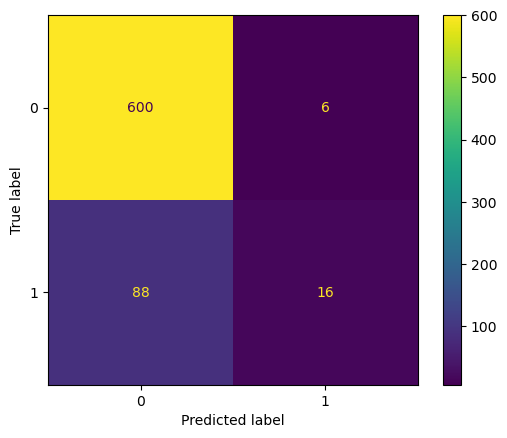

In [41]:
bn_model = BernoulliNB()
bn_model.fit(cv_X_train, y_train)
bn_pred = bn_model.predict(cv_X_test)

print(classification_report(y_test, bn_pred))

bn_cm = confusion_matrix(y_test, bn_pred)
ConfusionMatrixDisplay(bn_cm).plot()

In [42]:
print(bn_model.score(cv_X_train, y_train))
print(bn_model.score(cv_X_test, y_test))

0.9136715997181113
0.8676056338028169


In [43]:
roc_auc_score(y_test, bn_pred)

0.5719725818735719

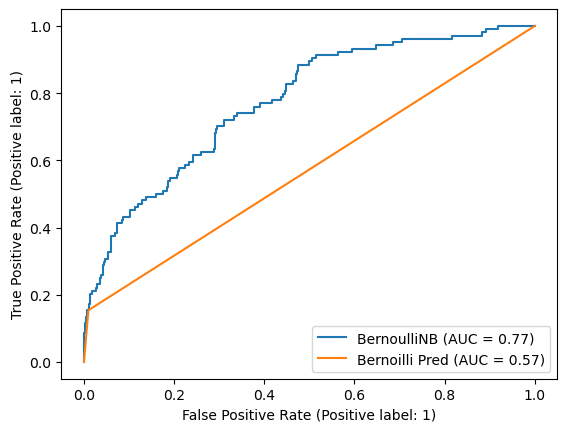

In [44]:
fig, ax = plt.subplots()

RocCurveDisplay.from_estimator(bn_model, cv_X_test, y_test, ax = ax)
RocCurveDisplay.from_predictions(y_test, bn_pred ,ax=ax,name="Bernoilli Pred")

### Random Forest

In [45]:
from sklearn.ensemble import RandomForestClassifier

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       606
           1       0.00      0.00      0.00       104

    accuracy                           0.85       710
   macro avg       0.43      0.50      0.46       710
weighted avg       0.73      0.85      0.79       710



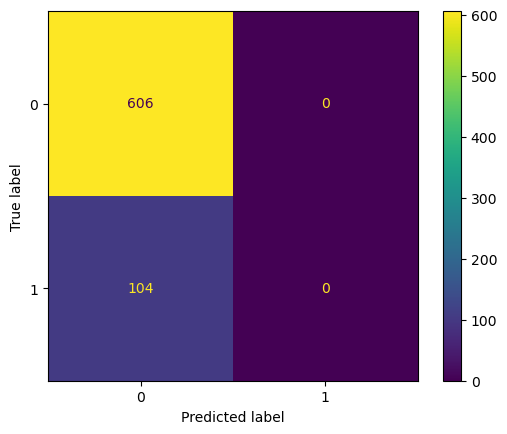

In [46]:
rf = RandomForestClassifier(n_estimators = 100, max_depth = 5)
rf.fit(cv_X_train, y_train)
rf_pred = rf.predict(cv_X_test)

print(classification_report(y_test, rf_pred))

rf_cm = confusion_matrix(y_test, rf_pred)
ConfusionMatrixDisplay(rf_cm).plot()

In [47]:
print(rf.score(cv_X_train, y_train))
print(rf.score(cv_X_test, y_test))

0.835799859055673
0.8535211267605634


In [48]:
roc_auc_score(y_test, rf_pred)

0.5

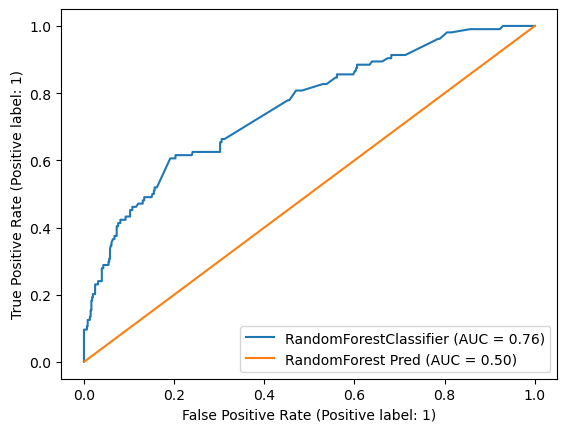

In [49]:
fig, ax = plt.subplots()

RocCurveDisplay.from_estimator(rf, cv_X_test, y_test, ax = ax)
RocCurveDisplay.from_predictions(y_test, rf_pred ,ax=ax,name="RandomForest Pred")

### Naive Bayes

In [50]:
from sklearn.naive_bayes import MultinomialNB

              precision    recall  f1-score   support

           0       0.90      0.95      0.93       606
           1       0.59      0.38      0.47       104

    accuracy                           0.87       710
   macro avg       0.74      0.67      0.70       710
weighted avg       0.85      0.87      0.86       710



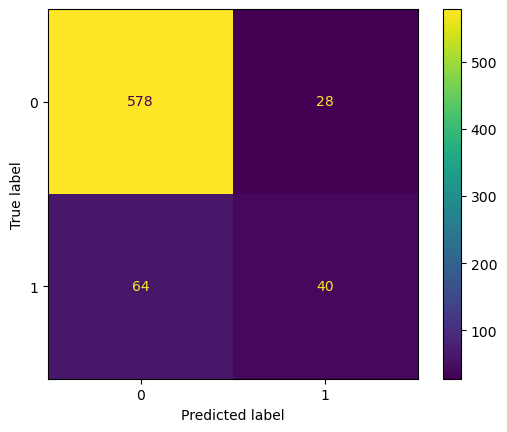

In [51]:
nb = MultinomialNB(alpha = 0.5)
nb.fit(cv_X_train, y_train)
nb_pred = nb.predict(cv_X_test)

print(classification_report(y_test, nb_pred))

nb_cm = confusion_matrix(y_test, nb_pred)
ConfusionMatrixDisplay(nb_cm).plot()

In [52]:
print(nb.score(cv_X_train, y_train))
print(nb.score(cv_X_test, y_test))

0.9548978153629316
0.8704225352112676


In [53]:
roc_auc_score(y_test, nb_pred)

0.6692053820766691

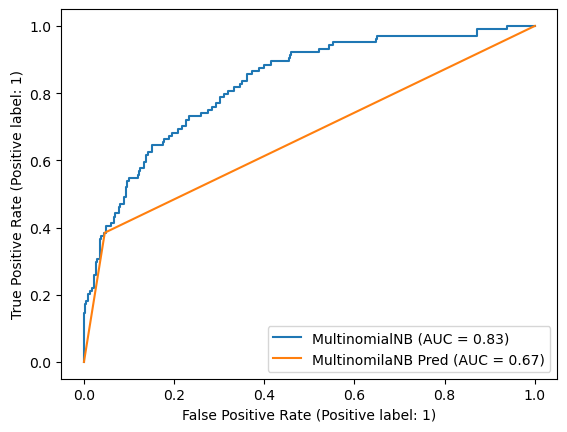

In [54]:
fig, ax = plt.subplots()

RocCurveDisplay.from_estimator(nb, cv_X_test, y_test, ax = ax)
RocCurveDisplay.from_predictions(y_test, nb_pred ,ax=ax,name="MultinomilaNB Pred")

### Compliment Naive Bayes

In [55]:
from sklearn.naive_bayes import ComplementNB

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       606
           1       0.43      0.54      0.48       104

    accuracy                           0.83       710
   macro avg       0.68      0.71      0.69       710
weighted avg       0.85      0.83      0.84       710



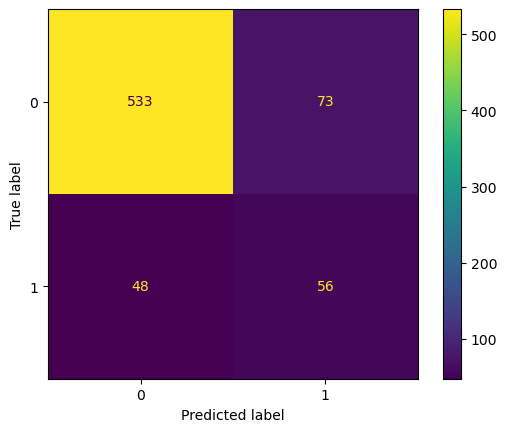

In [56]:
com_nb = ComplementNB(alpha = 0.05)
com_nb.fit(cv_X_train, y_train)
com_pred = com_nb.predict(cv_X_test)

print(classification_report(y_test, com_pred))

com_cm = confusion_matrix(y_test, com_pred)
ConfusionMatrixDisplay(com_cm).plot()

In [57]:
print(com_nb.score(cv_X_train, y_train))
print(com_nb.score(cv_X_test, y_test))

0.9573643410852714
0.8295774647887324


In [58]:
roc_auc_score(y_test, com_pred)

0.708999746128459

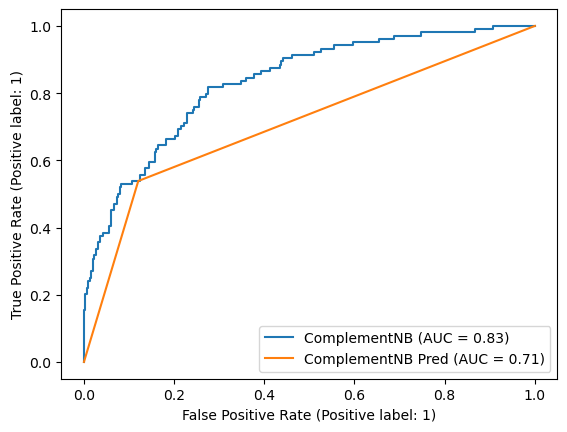

In [59]:
fig, ax = plt.subplots()

RocCurveDisplay.from_estimator(com_nb, cv_X_test, y_test, ax = ax)
RocCurveDisplay.from_predictions(y_test, com_pred ,ax=ax,name="ComplementNB Pred")

### Tuning

#### Imports

In [60]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

#### GridSearch

In [61]:
param_grid = {
    "gamma": [0.1, 1.0, 10, 100],
    "C": [0.1, 1.0, 10, 100]
}

In [62]:
grid_search = GridSearchCV(SVC(), param_grid, verbose=2)
grid_search.fit(cv_X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.6s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.4s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.4s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.4s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.4s
[CV] END ...................................C=0.1, gamma=1.0; total time=   0.5s
[CV] END ...................................C=0.1, gamma=1.0; total time=   0.5s
[CV] END ...................................C=0.1, gamma=1.0; total time=   0.5s
[CV] END ...................................C=0.1, gamma=1.0; total time=   0.5s
[CV] END ...................................C=0.1, gamma=1.0; total time=   0.5s
[CV] END ....................................C=0.1, gamma=10; total time=   0.5s
[CV] END ....................................C=0

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1.0, 10, 100],
                         'gamma': [0.1, 1.0, 10, 100]},
             verbose=2)

In [63]:
grid_search.best_params_

{'C': 10, 'gamma': 0.1}

In [64]:
grid_search.best_score_

0.873849889460218

In [65]:
print(grid_search.score(cv_X_train, y_train))
print(grid_search.score(cv_X_test, y_test))

0.9996476391825229
0.8887323943661972


In [66]:
grid_search.predict(cv_X_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

In [67]:
gs_best_model = grid_search.best_estimator_
gs_best_model

SVC(C=10, gamma=0.1)

              precision    recall  f1-score   support

           0       0.90      0.98      0.94       606
           1       0.74      0.38      0.50       104

    accuracy                           0.89       710
   macro avg       0.82      0.68      0.72       710
weighted avg       0.88      0.89      0.87       710



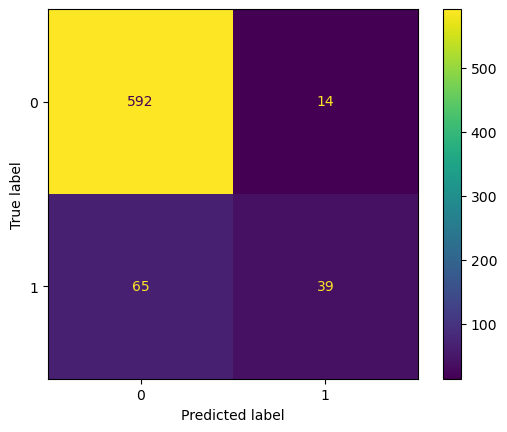

In [68]:
gs_best_model.fit(cv_X_train, y_train)
gs_pred = gs_best_model.predict(cv_X_test)

print(classification_report(y_test, gs_pred))

gs_cm = confusion_matrix(y_test, gs_pred)
ConfusionMatrixDisplay(gs_cm).plot()

In [69]:
roc_auc_score(y_test, gs_pred)

0.6759488448844885

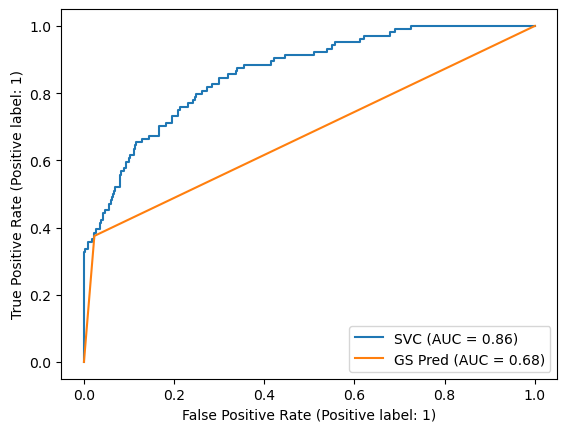

In [70]:
fig, ax = plt.subplots()

RocCurveDisplay.from_estimator(gs_best_model, cv_X_test, y_test, ax = ax)
RocCurveDisplay.from_predictions(y_test, gs_pred ,ax=ax,name="GS Pred")

#### Random hyperparameter opt

In [71]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

In [72]:
model = GradientBoostingRegressor()
parameters = {'learning_rate': [1e-5, .001, .01 , .1],
                  'subsample'    : sp_randFloat(),
                  'n_estimators' : sp_randInt(100, 1000),
                  'max_depth'    : sp_randInt(4, 12)
                 }

In [73]:
randm_src = RandomizedSearchCV(estimator=model, param_distributions = parameters,
                               cv = 2, n_iter = 10, n_jobs=-1)
randm_src.fit(cv_X_train, y_train)

RandomizedSearchCV(cv=2, estimator=GradientBoostingRegressor(), n_jobs=-1,
                   param_distributions={'learning_rate': [1e-05, 0.001, 0.01,
                                                          0.1],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f872f959c90>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f872f959690>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f872f93ffa0>})

In [74]:
randm_src.best_estimator_

GradientBoostingRegressor(learning_rate=0.01, max_depth=9, n_estimators=862,
                          subsample=0.8366798865526471)

In [75]:
randm_src.best_score_

0.22265496296522075

In [76]:
randm_src.best_params_

{'learning_rate': 0.01,
 'max_depth': 9,
 'n_estimators': 862,
 'subsample': 0.8366798865526471}

In [77]:
print(randm_src.score(cv_X_train, y_train))
print(randm_src.score(cv_X_test, y_test))

0.6632945027494663
0.21674792169537194


### Model Eval - TfidfVectorizer

#### Naive Bayes

              precision    recall  f1-score   support

           0       0.89      0.98      0.93       606
           1       0.72      0.28      0.40       104

    accuracy                           0.88       710
   macro avg       0.81      0.63      0.67       710
weighted avg       0.86      0.88      0.85       710



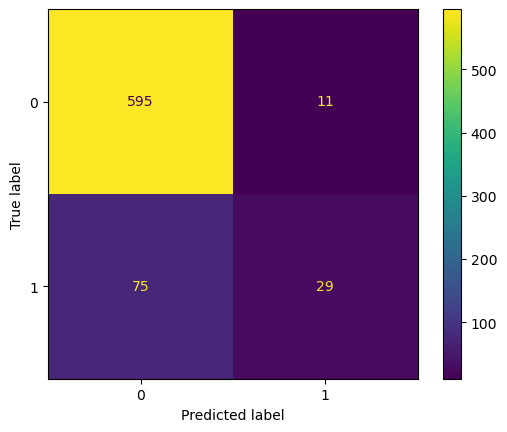

In [78]:
t_nb = MultinomialNB(alpha = 0.5)
t_nb.fit(X_train_vec, y_train)
tnb_pred = nb.predict(X_test_vec)

print(classification_report(y_test, tnb_pred))

tnb_cm = confusion_matrix(y_test, tnb_pred)
ConfusionMatrixDisplay(tnb_cm).plot()

In [79]:
print(t_nb.score(X_train_vec, y_train))
print(t_nb.score(X_test_vec, y_test))

0.9101479915433404
0.8732394366197183


In [80]:
roc_auc_score(y_test, tnb_pred)

0.6303471693323178

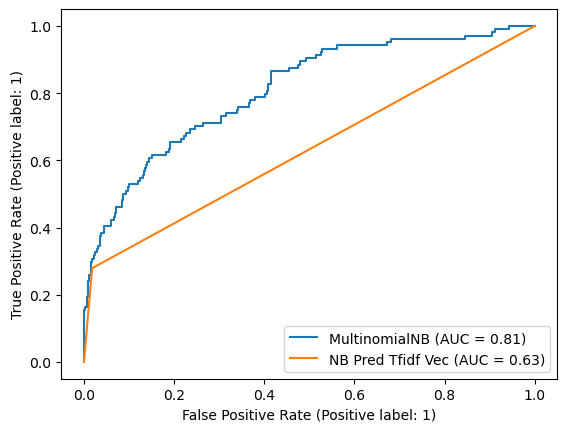

In [81]:
fig, ax = plt.subplots()

RocCurveDisplay.from_estimator(t_nb, X_test_vec, y_test, ax = ax)
RocCurveDisplay.from_predictions(y_test, tnb_pred ,ax=ax,name="NB Pred Tfidf Vec")

### Gridsearch Tfifd Vectorizer

In [82]:
tfidf_gs = GridSearchCV(SVC(), param_grid, verbose=2)
tfidf_gs.fit(X_train_vec, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.3s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.3s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.3s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.3s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.3s
[CV] END ...................................C=0.1, gamma=1.0; total time=   0.4s
[CV] END ...................................C=0.1, gamma=1.0; total time=   0.4s
[CV] END ...................................C=0.1, gamma=1.0; total time=   0.4s
[CV] END ...................................C=0.1, gamma=1.0; total time=   0.4s
[CV] END ...................................C=0.1, gamma=1.0; total time=   0.4s
[CV] END ....................................C=0.1, gamma=10; total time=   0.5s
[CV] END ....................................C=0

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1.0, 10, 100],
                         'gamma': [0.1, 1.0, 10, 100]},
             verbose=2)

In [83]:
tfidf_gs.best_params_

{'C': 100, 'gamma': 1.0}

In [84]:
tfidf_gs.best_score_

0.8759650495565989

In [85]:
print(tfidf_gs.score(X_train_vec, y_train))
print(tfidf_gs.score(X_test_vec, y_test))

1.0
0.895774647887324


In [86]:
tfidf_bm = tfidf_gs.best_estimator_
tfidf_bm 

SVC(C=100, gamma=1.0)

              precision    recall  f1-score   support

           0       0.90      0.99      0.94       606
           1       0.84      0.36      0.50       104

    accuracy                           0.90       710
   macro avg       0.87      0.67      0.72       710
weighted avg       0.89      0.90      0.88       710



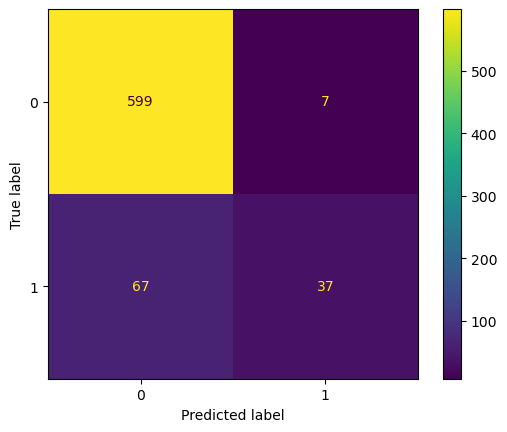

In [87]:
tfidf_bm.fit(X_train_vec, y_train)
tfidf_gs_pred = tfidf_gs.predict(X_test_vec)

print(classification_report(y_test, tfidf_gs_pred))

tfidf_gs_cm = confusion_matrix(y_test, tfidf_gs_pred)
ConfusionMatrixDisplay(tfidf_gs_cm).plot()

In [88]:
print(tfidf_bm.score(X_train_vec, y_train))
print(tfidf_bm.score(X_test_vec, y_test))

1.0
0.895774647887324


In [89]:
roc_auc_score(y_test, tfidf_gs_pred)

0.6721090378268596

### Streamlit